In [ ]:
import numpy as np
import math
from datascience import *
from scipy import stats
%matplotlib inline

# Welcome to IAS-150's Data Science Module

Today we will be examining a data set that the UN produces every year, called the Gender Inequality Index. This is the UN's annual ranking of 188 countries in  terms of gender _inequality_. We will be examining the subset of countries in Asia with complete data.

Gender equity is an essential and widely recognized international policy goal because of its intrinsic and instrumental value. It is clearly important as an end in itself and also is a means to the attainment of other development goals such as the nourishment and educational achievements of children.

The global Gender Inequality Index (GII) — built on the same framework as the UN's other ranking systems: the Human Development Index (HDI) and the Inequality-adjusted Human Development Index (IHDI) — was first released in 2010. It measures inequalities in achievements between women and men across three dimensions of human development: reproductive health, empowerment and the labour market. The GII can be used for international comparisons, but the global GII’s chosen indicators are deeply affected by data limitations.

The GII is computed using the association-sensitive inequality measure suggested by Seth (2009), which implies that the index is based on the general mean of general means of different orders — the first aggregation is by a geometric mean across dimensions; these means, calculated separately for women and men, are then aggregated using a harmonic mean across genders.

As we move along, we'll see how the global GII provides insights into gender disparities in reproductive health, empowerment and the labour market in Asian countries. It can enable governments, organiztions, and individuals to better understand and promote gender equality. The GII can be used to raise awareness of disparities, track progress towards gender equity, and support public action.

### Load in the UN Gender Inequality Index (GII) data from 2016
Note: the table has been modified slightly from its original format for ease of use. We've also added latitude and longitude so that we can display results on maps. The original table can be found at: http://hdr.undp.org/en/composite/GII

#### Clean Data:
###### (Only pay attention if you're interested)
Right now, all of the values that look like numbers are actually being stored as _strings_, which, in Python, are usually how ASCII characters are stored. Thus, you can't do normal mathematical operations on strings. We have to change these strings into _floats_, or floating-point decimals. That's what the code below does.

#### Note: 
The index we are interested in is NOT actually shown in this table. We're going to have to calculate it later. It involves layers of mathematical averages, which we'll try to explain, but they specifics aren't vital to this course.

In [ ]:
# load data
data = Table.read_table('data/asia-full-original-with-coords.csv')

# create an empty table, named asia
asia = Table()

# clean data
# a for loop iterates through a sequence and does something each time
# this one changes each value from a string to a number (a "float")
# and recreates the data in a new table, which we called 'asia'
for label in data.labels:
    clean_col = make_array()
    for i in np.arange(len(data.column(label))):
        if data.column(label).item(i) == '..':
            clean_col = np.append(clean_col, np.nan)
            
        elif label == data.labels[0]:
            clean_col = np.append(clean_col, data.column(label).item(i)) 
        #elif label == 'Country' or label == 'HDI rank':
            #clean_col = np.append(clean_col, data.column(label).item(i))   
        else:
            clean_col = np.append(clean_col, float(data.column(label).item(i)))
    asia.append_column(label, clean_col)

# display table
asia

# An Introduction to Python

**Topics covered:**
* Variables
* Functions 
* Dot notation
* Using libraries
* Datascience library

## Variables

In programming, we often compute many values that we want to save so that we can use the result in a later step. For example, let's say that we want to find the number of seconds in a day. We can easily calculate this with the following:

                            60 * 60 * 24 = 86400 seconds

However, let's say that your friend Alexander asked you how many seconds there are in three days. We could, of course, perform the calculation in a similar manner:

                            (60 * 60 * 24) * 3 = 259200 seconds

But we see that we repeated the calculation in parentheses above. Instead of doing this calculation again, we could have saved the result from our first step (calculating the number of seconds in a day) as a variable.

In [24]:
# This is Python code that assigns variables.
# The name to the left of the equals sign is the variable name.
# The value to the right of the equals sign is the value of the variable.
# Press Shift-Enter to run the code and see the value of our variable!

seconds_in_day = 60 * 60 * 24 # This is equal to 86400.
seconds_in_day

86400

Then, we can simply multiply this variable by three to get the number of seconds in three days:

In [26]:
# The code below takes the number of seconds in a day (which we calculated in the previous code cell)
# and multiplies it by 3 to find the number of seconds in 3 days.

seconds_in_three_days = seconds_in_day * 3  # This is equal to 259200.
seconds_in_three_days

259200

As you can see, variables can be used to simplify calculations, make code more readable, and allow for repetition and reusability of code.

## Functions

So far, you've learnt how to assign variables to certain values. Now, let's learn how we can manipulate some of these values.

Let's say we want to perform a certain operation on many different inputs that will produce distinct outputs. What do we do? We write a **_function_**.

A function is a block of code which works a lot like a machine: it takes an input, does something to it, and produces an output.

The input is put between brackets and can also be called the _argument_ or _parameter_. Functions can have multiple arguments.

Try running the cell below after changing the variable _name_:

In [1]:
# Edit this cell to your own name!
name = "John Doe"

# Our function
def hello(name):
    return "Hello " + name + "!"

hello(name)

'Hello John Doe!'

Interesting, right? Now, you don't need to write 10 different lines with 10 different names to print a special greeting for each person. All you need to is write one function that does all the work for you!

Now, let's write our own function. Let's look at the following rules:

## Defining##

* All functions must start with the "def" keyword.
* All functions must have a name, followed by parentheses, followed by a colon. Eg. def hello( ):
* The parentheses may have a variable that stores its arguments (inputs)
* All functions must have a "return" statement which will return the output. Think of a function like a machine. When you put something inside, you want it to return something. Hence, this is very important.

## Calling##

After you define a function, it's time to use it. This is known as _calling_ a function.

To call a function, simply write the name of the function with your input variable in brackets (argument).

In [4]:
# Complete this function
def #name(argument):
    return # function must return a value

# Calling our function below...
my_first_function(name)

SyntaxError: invalid syntax (<ipython-input-4-0919a320d65c>, line 2)

Great! Now let's do some math. Let's write a function that returns the square of the input.

Try writing it from scratch!

In [ ]:
# square function 


square(5)

Neat stuff! Try different inputs and check if you get the correct answer each time.

You've successfully written your first function from scratch!

## Dot Notation##

Above, we've seen that we can directly call functions with the arguments within the parentheses that follow. For example _square(5)_ is calling the function _square_ with an argument of _5_. 

We're not limited to just that though! We can also utilize something called _dot notation_ to directly call functions on a given variable. Take a look at the code below:

In [1]:
nums = make_array(1,2,3) # creates a list of numbers
nums.max() # trying to find the max of the list

NameError: name 'make_array' is not defined

In [ ]:
max(nums)

Notice that the two pieces of code above produced the same output. This is because they're equivalent! 

In the first bit of code, _nums.max()_ is calling the function _max()_ directly on the _nums_ variable, which is a list. Thus, our code knows to look into _nums_'s methods and apply the _max()_ function on this particular list.

_max(nums)_ differs in that it calls the _max_ function on the argument that we passed in, which is _nums_ in this case, rather than looking up what methods _nums_ has. 

We'll see more examples of this later on in the module.

## Using Libraries##

Rather than always writing our own functions, we can also utilize functions already made by others. Python allows us to **import** other code, creating a **module** that contains all of the names created by that code.

Python includes many useful modules that are just an import away. We'll look at the ```math``` module as a first example. The ```math``` module is extremely useful in computing mathematical expressions in Python.

Suppose we want to very accurately compute the area of a circle with radius 5 meters. For that, we need the constant $\pi$, which is roughly 3.14. Conveniently, the ```math``` module has ```pi``` defined for us:

In [ ]:
import math
radius = 5
area_of_circle = radius**2 * math.pi
area_of_circle

```pi``` is defined inside ```math```, and the way that we access names that are inside modules is by writing the module's name, then a dot, then the name of the thing we want:

                            ```<module name>.<name>```

In order to use a module at all, we must first write the statement import ```<module name>```. That statement creates a module object with things like ```pi``` in it and then assigns the name ```math``` to that module. Above we have done that for ```math```.

Note how different methods take in different number of arguments. Often, the documentation of the module will provide information on how many arguments is required for each method.

In [ ]:
# Calculating factorials.
math.factorial(5)

In [ ]:
# Calculating square roots.
math.sqrt(5)

### Datascience Libraries ###

[can add Table functions here if we think it's necessary]

# How the GII is calculated:
![](gii_breakdown.png)

The Gender Inequality Index (GII) reflects gender-based disadvantage in three dimensions—reproductive health, empowerment and the labour market—for as many countries as data of reasonable quality allow. It shows the loss in potential human development due to inequality between female and male achievements in these dimensions. It ranges from 0, where women and men fare equally, to 1, where one gender fares as poorly as possible in all measured dimensions. 

## The 3 Dimensions:

### 1. Reproductive Health
Measured by 2 indicators: the maternal mortality ratio and the adolescent fertility rate. 

These indicators are used because the degree to which a society prioritizes the well-being of women during childbirth is intrinsically important, and is also a clear signal of women’s status in society. In many countries around the world, the risk of death in childbirth could be significantly reduced through the provision of basic education, contraceptives, antenatal health services and skilled birth attendance. Adolescent childbearing tends to prevent young women from achieving higher levels of education, which is necessary for success in the labour market and accessing other life opportunities. Early childbirth also poses significant health risks for the mother and her baby. Some studies suggest that because their bodies are not yet fully developed, teenage mothers’ risk of death in childbirth is five times higher.

### 2. Empowerment
Measured by two indicators: the share of parliamentary seats held by each sex, and secondary and higher education attainment levels (percentages of men and women, 25 years and above, who have at least a secondary education).

Women have traditionally been disadvantaged in the political arena at all levels of government. Estimates for parliamentary representation at the national level reflect women’s visibility in political leadership and society more generally, and the extent to which women hold high offices. In turn, higher levels of educational attainment expand women’s freedoms by strengthening their capacity to question, reflect and act, and also to access information. Educated women are more likely to enjoy meaningful work, to use their voices in public debate, to be able to care for their own health and that of their family, and to act as agents throughout society. Secondary and higher educational attainment are used because disparities in these levels strongly affect women’s career and leadership prospects.

### 3. Labor
Measured by labor force participation rate in males and females, which is the percentage of individuals of each gender who work.

Women may not participate in the labour market for several reasons, including exclusion, unequal pay and incentives, household duties or caring for relatives, and pregnancy and childcare. Thus, the level of women’s participation reflects several aspects, including possibilities and permission to work, which in turn includes labour market opportunities, and the capability of women to combine productive work with duties of care and reproductive responsibilities. Clearly this is affected also by men’s complementary activities in the household.

### Data sources:
The GII relies on data from the following publicly available databases:
- Maternal mortality ratio (MMR): UN Maternal Mortality Estimation Group (2016) [used to from UNICEF’s The State of the World’s Children]
- Adolescent birth rate (ABR): UN Department of Economic and Social Affair’s World Population Prospects (UNDESA)
- Share of parliamentary seats held by each sex (PR): International Parliamentary Union (IPU)
- Attainment at secondary and higher education levels (SE): UNESCO Institute for Statistics (2016) [Educational attainment statistics from Barro and Lee (2010) datasets]
- Labour market participation rate (LFPR): International Labour Organization’s LABORSTA database (ILO)

Data from the above sources, compiled by country, can be accessed through the International Human Development Indicators website at: http://HDR.undp.org/en/data/profiles/.

## A step-by-step calculation:
There are five steps to computing the GII. For both of the women’s reproductive health indicators - the maternal mortality rate (MMR) and the average fertility rate (AFR) - an inverse of each indicator is taken. An inverse of a number is equal to one divided by that number. An inverse of a number decreases as the number increases. Given that a higher value of the MMR or the AFR indicates a worse health outcome, the inverses of both indicators are used while constructing the GII. The rest of the three indicators, share of parliamentary seats held (PR), attainment at secondary and higher education (SE) and labour market participation rate (LFPR), are already available in percentage terms, and thus are automatically normalized between zero and hundred.

### NOTE: The Arithmetic mean, Geometric mean, and Harmonic mean

The GII is based on the principle that both inequality between dimensions and inequality between genders should be penalised. For this reason the GII is based on the mathematical formulation of the generalized mean of generalized means of different orders.

- First, we apply the geometric mean to penalise inequality across dimensions.
- Second, we use the harmonic mean to penalise even more the inequality between genders.


Below are a lot of Python functions that wrap up the mathematical formula used to calculate the GII. It's rather complicated-seeming, but the idea is to take the average across the 3 dimensions for each gender separately, and then find a sort of average between the genders, that marks how far they are from each other - thus, if they are closer to 0 (closer to 0 distance apart), there is more gender equality.

In [ ]:
# calculate female health using geometric mean
def fhealth(mmr, abr):
    # stats.mstats.gmean is a function (for computing geometric means) that comes from the scipy library
    # so we did not have to write it ourselves
    return stats.mstats.gmean([10 / mmr, 1 / abr])

# male health is 1 by default - because they do not do childbirth
mhealth = 1

In [ ]:
# calculate either male or female empowerment using geometric mean
def empowerment(pr, se):
    return stats.mstats.gmean([pr, se])

In [ ]:
# aggregate across dimensions to get female gender index, geometric mean again
def within_female_across_dimensions(hlth, emp, lbr):    # inputs will be fhealth(..., ...), empowerment(..., ...), flabor
    # gmean of gmeans
    return stats.mstats.gmean([hlth, emp, lbr])

In [ ]:
# aggregate across dimensions to get male gender index
def within_male_across_dimensions(hlth, emp, lbr):
    return stats.mstats.gmean([hlth, emp, lbr])

In [ ]:
# aggregate between male and female for each dimension
# The female and male indices are aggregated by the harmonic mean to create the equally distributed gender index
def across_gender_within_dimension(female, male):
    # harmonic mean
    return stats.mstats.hmean([female, male])

In [ ]:
# combine above functions into one big one that does all the work!
# input: a table like asia
# output: a new table, a copy of the input, with another column that has the calculated GII

# had to shift row indices by 1 because asia table has 1 less column
def gii_calculator(table):
    def step4(): 
        # aggregate female and male indices using equal weights 
        #(thus treating the genders equally) 
        # and then aggregating the indices across dimensions
        return stats.mstats.gmean([np.mean([fhealth(mmr, abr), mhealth]), np.mean([empowerment(fpr, fse), empowerment(mpr, mse)]), np.mean([flabor, mlabor])]) 
    gii_column = make_array()
    for i in np.arange(len(table.column(0))): # row indices of table
        row = table.row(i)
        mmr = row.item(3)
        abr = row.item(4)
        fpr = row.item(5)   # female representation, male = 100 - female
        mpr = 100 - fpr
        # need fse and mse
        fse = row.item(6) 
        mse = row.item(7)
        flabor = row.item(8)
        mlabor = row.item(9)
        # BELOW IS THE STEP WHERE THE CALCULATION ACTUALLY HAPPENS
        # NOTICE that it is one variable that contains many functions within functions!
        gii = 1 - (
        across_gender_within_dimension(
            within_female_across_dimensions(fhealth(mmr, abr), empowerment(fpr, fse), flabor), 
            within_male_across_dimensions(mhealth, empowerment(mpr, mse), mlabor)
        )
        / step4()
        )
        gii_column = np.append(gii_column, gii)
    with_gii = table.copy().with_column("GII (2016)", gii_column)
    return with_gii

In [ ]:
# new table with 2016 GII score
asia_gii = gii_calculator(asia)
asia_gii

## Data Analysis
Let's check out the distribution of GII scores in a _histogram_. 

A _histogram_ is a continuous graph that allows us to see the number of data items that fall into each interval. The data is split into _bins_ that categorizes the information into specified numerical groups, and we can observe the frequency of occurrences by calculating the area of a given bar (width times height of bar). 

In addition, while there can be empty bins, there musn't be gaps in the range of bin values since a histogram depicts continuous data. For instance, the bin from 0.3 to 0.4 can be empty but it must still exist on the graph to represent the continous range of GII values.

Since bins measure frequency and are represented in percents, the total area of all of the bars should sum to 100%. This characteristic is true for all histograms since a histogram represents the distribution of the data across all the specified bins.

Through the `datascience` library, we have access to a `hist` function that plots a histogram from an `array`. The `hist` function is called on a table, and takes a column name (as a `string`) as its input. In the cell below, try to call the function yourself and plot a histogram of the distribution of all GII scores from 2016. 

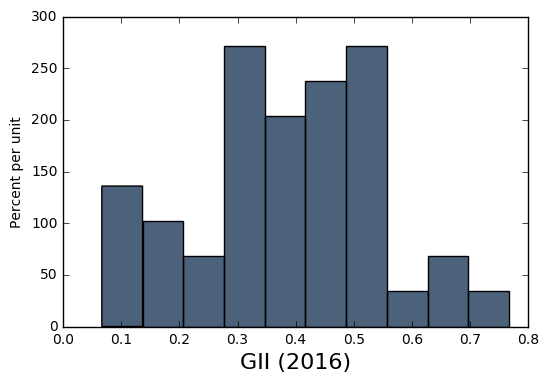

In [10]:
# SOLUTION
asia_gii.hist("GII (2016)")

If you're curious about a more mathematical perspective of a histogram, take a look at the following calculation:

With the above histogram, we can see that for the bin of 0.1 to 0.2, the height of the bar is roughly 100 percent per unit. Since the frequency for a given bin can be calculated through the bar's area (width x height), this bin has a frequency of (0.2 - 0.1) x 100 = 10 percent.

Also, if we were to calculate the frequency for each of the possible bins, we would be able to notice that all of the areas sum up to 100%.

#### Average GII?
Now try to get an average GII score for Asian countries. There are several different ways that you could do this, but let's use the `mean` function, which is built into the Python language. 

First, we will need to extract the column (an array) that we want from the `asia_gii` table, then we can call the `mean` function on it, using dot notation, with empty parentheses at the end. 

In [ ]:
# SOLUTION
asia_gii.column("GII (2016)").mean()

# Visualizations

Let's now start looking at some of the data visually. An obvious way to do this is by using a geographical map of all the countries.

To start, we'll create a function that allows the labels on our map to include both the country name and GII score, so we can easily see the data that we want.

In [ ]:
# function to generate text for each country with name and GII
def getPopupText(country, gii):
    "Create custom popup content"
    #the_text = ("%s, GII Score: %d" % (country, gii))
    the_text = country + ", GII Score: " + str(gii)
    return the_text

# Apply the function to the GII column of table
asia_gii['popup'] = asia_gii.apply(lambda x , y: getPopupText(x,y), 0,'GII (2016)')

# View the table - see what we've added?
asia_gii

We can now plot the data on a simple world map...

In [ ]:
# plot simple graph
Marker.map(asia_gii['Latitude'], asia_gii['Longitude'], labels=asia_gii['popup'])
#Marker.map(asia_gii['Latitude'], asia_gii['Longitude'], labels=asia_gii['Country'])

Now let's categorize the GII scores by color. We'll use the histogram above and some basic statistical principals to decide which scores are relatively "good" or "bad".

Rather than arbitrarily determining some values as "good" and some as "bad", we can utilize _standard deviations_ to help us make objective decisions as to how "good" or "bad" a country's GII is.

Standard deviation is a measure of how much a specific data point differs from the average of all the data. The specific formula for calculating the standard deviation is shown below if you're interested. Otherwise, simply know that we can find the standard deviation for a given list of values by calling ```numpy```'s ```std``` function on the list (shown as ```np.std(list)```). 

<img src="stddev.png" alt="Drawing" style="width: 200px;"/>

For our purposes, if a country has a GII that is greater than half a standard deviation from the mean, that means this country's GII is higher than the average GII. Thus, this country has what we consider a "bad" GII, so we want to show these countries as a different color. 

Similarly, if a country has a GII that is more than half a standard deviation under the mean, that means this country has a particulary low GII and we thus want to depict it with a different color as well.

In [14]:
# Category map - symbolized by color

# Set colors for each gii cutoff point
asia_gii['color'] = 'green' # set default color to green

std_dev = np.std(asia_gii['GII (2016)']) # can use np's function to find the standard deviation
mean = np.mean(asia_gii['GII (2016)'])   # this is a different way of finding the mean than above
print("This is the standard deviation:", std_dev)
print("This is the mean:", mean)

# modify the "extreme" values' colors based on how far the GII is from the mean of 0.38
# since the GII's are relatively close to one another, we set a country to have an "extreme" GII 
# if its GII lies outside of half a standard deviation from the mean

# countries with GII that are greater than mean + 0.5 * std_dev are considered "bad"
asia_gii['color'][asia_gii['GII (2016)'] >= mean + 0.5 * std_dev] = 'red'  # high GII - bad

# countries with GII that are less than mean - 0.5 * std_dev are considered "good"
asia_gii['color'][asia_gii['GII (2016)'] < mean - 0.5 * std_dev] = 'blue'  # low GII - good

This is the standard deviation: 0.16537360824
This is the mean: 0.385229812299


Are there certain geographic areas where GII tends to be lower or higher? Discuss with your group.

In [15]:
Marker.map(asia_gii['Latitude'], asia_gii['Longitude'], labels=asia_gii['popup'], colors=asia_gii['color'])
#Marker.map(asia_gii['Latitude'], asia_gii['Longitude'], labels=asia_gii['Country'], colors=asia_gii['color'])

We can also draw a map that scales circles based on GII score. . .

Again, we will create a function that does the work of finding the right size of the circle for us, then append that size as a column to our table, which we will then use as an input to the function that generates the actual map.

In [ ]:
def scaleSymbolSize(theData, dataVal, minRadius=10, maxRadius=300):
    """
    Scale symbol size between the range of min and max radii
    based on range of values in the input data. 
    Then use this radius to determine the output symbol AREA
    Returns the AREA for the symbol
    """
    valMin = min(theData)
    valMax = max(theData)
    valRange = (valMax - valMin )  
    symRange = (maxRadius - minRadius)  
    symbol_radius = (((dataVal - valMin) * symRange) / valRange) + minRadius
    symbol_area = symbol_radius * symbol_radius * math.pi  # Area of a circle = piR^2
    return int(symbol_area)

In [ ]:
asia_gii['circle_area'] = asia_gii.apply(lambda x: scaleSymbolSize(asia_gii['GII (2016)'], x, 100, 1500000), 'GII (2016)')
# notice the new "circle_area" column
asia_gii

In [ ]:
Circle.map_table(asia_gii.select(['Latitude','Longitude', 'popup','color','circle_area']), fill_opacity=.8)
#Circle.map_table(asia_gii.select(['Latitude','Longitude','Country','color','circle_area']), fill_opacity=.8)

Remember that a larger circle means MORE INEQUALITY! (which is bad!)

# Activity:

With a partner, choose an Asian country that you are both interested in (WITHOUT looking back at the numbers in the table), and make some educated guesses about what numbers you think this country would have in each of the categories we've been using. 

Then, use your estimates to calculate this country's GII below. 

Was it higher or lower than you expected? What about compared to the country's real GII and data values?

In [19]:
# we are going to use the append function to append a row to an empty table 
# a table that has all the necessary columns to do the calculation

﻿Country,Overall HDI Rank (2015),Within Region HDI Rank (2015),"Maternal mortality ratio (deaths per 100,000 live births)","Adolescent birth rate (births per 1,000 women ages 15–19)",Share of seats in parliament (% held by women),% Female population with at least some secondary education,% Male population with at least some secondary education,Female Labour force participation rate,Male Labour force participation rate


In [20]:
# country is now an empty table - next, we will input your chosen data
my_country = Table(make_array(asia.labels[:-2])[0])
my_country

﻿Country,Overall HDI Rank (2015),Within Region HDI Rank (2015),"Maternal mortality ratio (deaths per 100,000 live births)","Adolescent birth rate (births per 1,000 women ages 15–19)",Share of seats in parliament (% held by women),% Female population with at least some secondary education,% Male population with at least some secondary education,Female Labour force participation rate,Male Labour force participation rate
hi,0,0,11,2,20,80,90,50,70


In [21]:
# add a row with your estimated input for each of the columns above, IN ORDER
# Country should be a string, like "China"
# Overall HDI Rand and Within Region HDI Rank are set to 0 because they are not relevant to this calculation
my_country.append([..., 0, 0, ..., ..., ..., ..., ..., ..., ...])
my_country

In [22]:
# calculate the gii of your new country!
est_gii = gii_calculator(my_country)
est_gii

Write a paragraph (and be ready to present!) explaining why your country has the numbers it did. Were you suprised by how high or low it ranked compared to other countries "around it"? 

# Limitations of the Global GII

The GII’s use of reproductive health indicators has been quentioned. Naturally, data for the two indicators are only available for women, making interpretations of the GII problematic. The GII responds to this discrepancy by giving men a value of “one” in this dimension—a value which signifies that men have achieved the best possible outcome here. However, a measure of inequality must consist of measurable achievements for all the groups involved. The two indicators—maternal mortality ratio and adolescent fertility rate—should instead, it is said, be used to construct an index that compares the state of women across countries, rather than a gender inequality index, comparing the situation between women and men.

Additionally, the value of the GII doesn’t tell us which gender is doing better or worse. Instead the GII score tells us the level of inequality between two groups—men and women—but not which group is disadvantaged.

Meanwhile, several other gender indices are used by different world institutions, such as the World Economic Forum’s Global Gender Gap Index (GGI), the Economist Intelligence Unit’s Women’s Economic Opportunity Index (WEOI), the OECD’s Social Institutions and Gender Index (SIGI), and the Gender Equity Index (GEI) developed by Social Watch. They differ from the GII in many ways yet can be useful complements as we seek to understand the underlying causes of gender inequalities in economic participation.